In [1]:
import pandas as pd
import sqlite3
import random
import requests

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO

In [2]:
conn = sqlite3.connect('data/sqlite/nfl_data.sqlite')

In [3]:
teams_df = pd.read_sql('SELECT * FROM teams', conn).set_index('abbreviation')

In [74]:
games_df = pd.read_sql('SELECT * FROM games', conn).set_index('gameId')

In [56]:
plays_df = pd.read_sql('SELECT * FROM plays', conn).set_index('play_uuid')

In [79]:
#tracking_df = pd.read_sql('SELECT * FROM tracking', conn)
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['club'] = tracking_df['club'].replace('LA', 'LAR').replace('WAS', 'WSH')

In [80]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')] #| (tracking_df['event'] == 'autoevent_ballsnap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [81]:
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
snap_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
snap_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6323)

In [82]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[snap_ids]
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,converted
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LAR,...,0.600181,-0.014850,0.014850,2.126690,0.562363,None,None,NaN,NaN,0
2022090800.1187,2022090800,1187,47853,Darrell Henderson,(8:48) D.Henderson right tackle to LA 44 for 4...,2,1,10,LAR,BUF,...,0.792763,0.006345,-0.006345,2.123537,-0.042901,None,None,NaN,NaN,0
2022090800.1254,2022090800,1254,46830,Brandon Powell,(7:20) (Shotgun) B.Powell left tackle to BUF 4...,2,1,10,LAR,BUF,...,0.772788,0.008701,-0.008701,3.117542,0.550017,Defensive Holding,None,42395.0,NaN,0
2022090800.1385,2022090800,1385,47853,Darrell Henderson,(4:14) D.Henderson left end to BUF 7 for 18 ya...,2,1,10,LAR,BUF,...,0.764799,0.027923,-0.027923,4.027252,1.463392,None,None,NaN,NaN,1
2022090800.1406,2022090800,1406,47853,Darrell Henderson,(3:42) D.Henderson up the middle to BUF 4 for ...,2,1,7,LAR,BUF,...,0.736876,0.000100,-0.000100,5.490634,0.118456,None,None,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022110700.612,2022110700,612,47896,Justice Hill,(3:44) (Shotgun) J.Hill left end to NO 40 for ...,1,1,10,BAL,NO,...,0.533628,0.047439,-0.047439,3.753480,-1.229170,None,None,NaN,NaN,0
2022110700.670,2022110700,670,46101,Lamar Jackson,(2:09) (Shotgun) L.Jackson left end to NO 24 f...,1,3,1,BAL,NO,...,0.540354,-0.023838,0.023838,3.966451,0.552217,None,None,NaN,NaN,1
2022110700.80,2022110700,80,44879,Alvin Kamara,(14:24) (Shotgun) A.Kamara right tackle to NO ...,1,1,10,NO,BAL,...,0.416139,-0.001371,0.001371,2.335142,-0.482939,None,None,NaN,NaN,0


In [83]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(snap_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [84]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
# Select the play record
play = all_22_plays_df.iloc[random_play]
random_id = play.name
play

gameId                                                                     2022100907
playId                                                                           1519
ballCarrierId                                                                   54501
ballCarrierDisplayName                                                    Breece Hall
playDescription                     (6:08) Br.Hall left end pushed ob at MIA 23 fo...
quarter                                                                             2
down                                                                                2
yardsToGo                                                                           3
possessionTeam                                                                    NYJ
defensiveTeam                                                                     MIA
yardlineSide                                                                      MIA
yardlineNumber                                        

In [85]:
# Select the tracking player positions from ball-snap for this play
play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == play.name)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
783937,2022100907,1519,33107.0,Duane Brown,6,2022-10-09 14:10:49.799999,71.0,NYJ,left,45.840000,22.890000,0.20,1.37,0.02,272.61,220.79,ball_snap,2022100907.1519
784008,2022100907,1519,38548.0,Melvin Ingram,6,2022-10-09 14:10:49.799999,6.0,MIA,left,44.160000,19.410000,0.74,2.04,0.07,60.48,24.17,ball_snap,2022100907.1519
784079,2022100907,1519,42371.0,Laken Tomlinson,6,2022-10-09 14:10:49.799999,78.0,NYJ,left,46.070000,24.280000,0.55,1.99,0.05,238.36,135.45,ball_snap,2022100907.1519
784150,2022100907,1519,42500.0,C.J. Uzomah,6,2022-10-09 14:10:49.799999,87.0,NYJ,left,46.250000,19.660000,0.06,0.06,0.05,271.70,231.79,ball_snap,2022100907.1519
784221,2022100907,1519,43433.0,Connor McGovern,6,2022-10-09 14:10:49.799999,60.0,NYJ,left,45.100000,25.900000,0.70,2.53,0.07,266.80,203.47,ball_snap,2022100907.1519
784292,2022100907,1519,43503.0,Elandon Roberts,6,2022-10-09 14:10:49.799999,52.0,MIA,left,40.470000,26.610000,0.03,0.35,0.01,87.25,121.59,ball_snap,2022100907.1519
784363,2022100907,1519,46142.0,Jerome Baker,6,2022-10-09 14:10:49.799999,55.0,MIA,left,41.340000,21.740000,0.59,2.25,0.07,91.26,91.59,ball_snap,2022100907.1519
784434,2022100907,1519,46226.0,Tyler Conklin,6,2022-10-09 14:10:49.799999,83.0,NYJ,left,45.850000,21.380000,0.14,1.16,0.01,305.19,231.61,ball_snap,2022100907.1519
784505,2022100907,1519,46307.0,Zach Sieler,6,2022-10-09 14:10:49.799999,92.0,MIA,left,44.100000,23.300000,0.30,1.81,0.04,96.77,83.17,ball_snap,2022100907.1519
784576,2022100907,1519,47796.0,Christian Wilkins,6,2022-10-09 14:10:49.799999,94.0,MIA,left,44.260000,28.560000,0.59,1.08,0.06,96.98,161.64,ball_snap,2022100907.1519


In [86]:
last_frame_id = tracking_df.loc[(tracking_df['play_uuid'] == play.name)]['frameId'].max()
last_frame = tracking_df.loc[((tracking_df['play_uuid'] == play.name) & (tracking_df['frameId'] == last_frame_id))]
last_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
784002,2022100907,1519,33107.0,Duane Brown,71,2022-10-09 14:10:56.299999,71.0,NYJ,left,43.100000,11.44,0.68,0.24,0.07,249.26,256.98,NaN,2022100907.1519
784073,2022100907,1519,38548.0,Melvin Ingram,71,2022-10-09 14:10:56.299999,6.0,MIA,left,39.550000,7.04,2.27,2.21,0.24,250.33,244.74,NaN,2022100907.1519
784144,2022100907,1519,42371.0,Laken Tomlinson,71,2022-10-09 14:10:56.299999,78.0,NYJ,left,50.660000,14.38,1.37,0.46,0.14,263.43,259.32,NaN,2022100907.1519
784215,2022100907,1519,42500.0,C.J. Uzomah,71,2022-10-09 14:10:56.299999,87.0,NYJ,left,30.740000,1.64,2.84,2.65,0.29,145.55,184.41,NaN,2022100907.1519
784286,2022100907,1519,43433.0,Connor McGovern,71,2022-10-09 14:10:56.299999,60.0,NYJ,left,45.880000,18.32,1.07,0.56,0.11,267.47,265.12,NaN,2022100907.1519
784357,2022100907,1519,43503.0,Elandon Roberts,71,2022-10-09 14:10:56.299999,52.0,MIA,left,42.610000,7.07,5.27,1.37,0.53,233.97,239.39,NaN,2022100907.1519
784428,2022100907,1519,46142.0,Jerome Baker,71,2022-10-09 14:10:56.299999,55.0,MIA,left,42.640000,0.61,0.24,0.37,0.03,295.21,146.11,NaN,2022100907.1519
784499,2022100907,1519,46226.0,Tyler Conklin,71,2022-10-09 14:10:56.299999,83.0,NYJ,left,33.270000,1.23,2.50,2.75,0.26,227.61,259.34,NaN,2022100907.1519
784570,2022100907,1519,46307.0,Zach Sieler,71,2022-10-09 14:10:56.299999,92.0,MIA,left,31.140000,0.11,4.24,3.33,0.45,214.14,227.00,NaN,2022100907.1519
784641,2022100907,1519,47796.0,Christian Wilkins,71,2022-10-09 14:10:56.299999,94.0,MIA,left,32.130000,5.47,4.60,2.77,0.47,216.85,211.33,NaN,2022100907.1519


In [87]:
# Select the game for this play
game = games_df.loc[play['gameId']]
game

season                     2022
week                          5
gameDate             10/09/2022
gameTimeEastern        13:00:00
homeTeamAbbr                NYJ
visitorTeamAbbr             MIA
homeFinalScore               40
visitorFinalScore            17
Name: 2022100907, dtype: object

In [88]:
# Load the Home team logo from the ESPN API 
response = requests.get(teams_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(teams_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [89]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_17498/4208403530.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


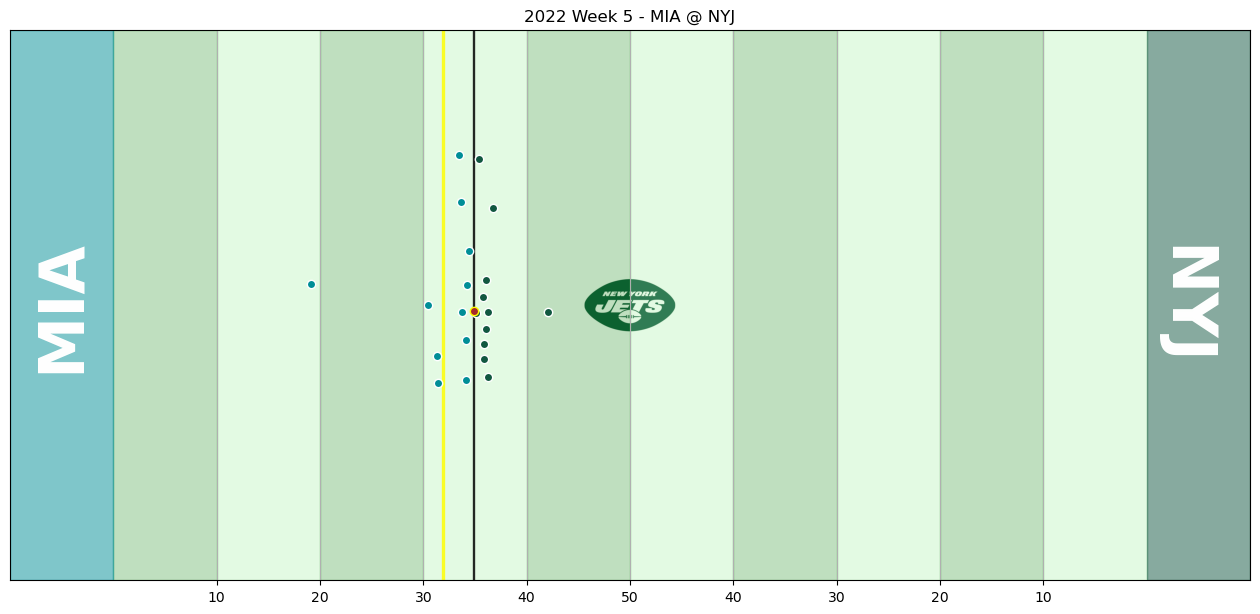

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_17498/4208403530.py:124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']


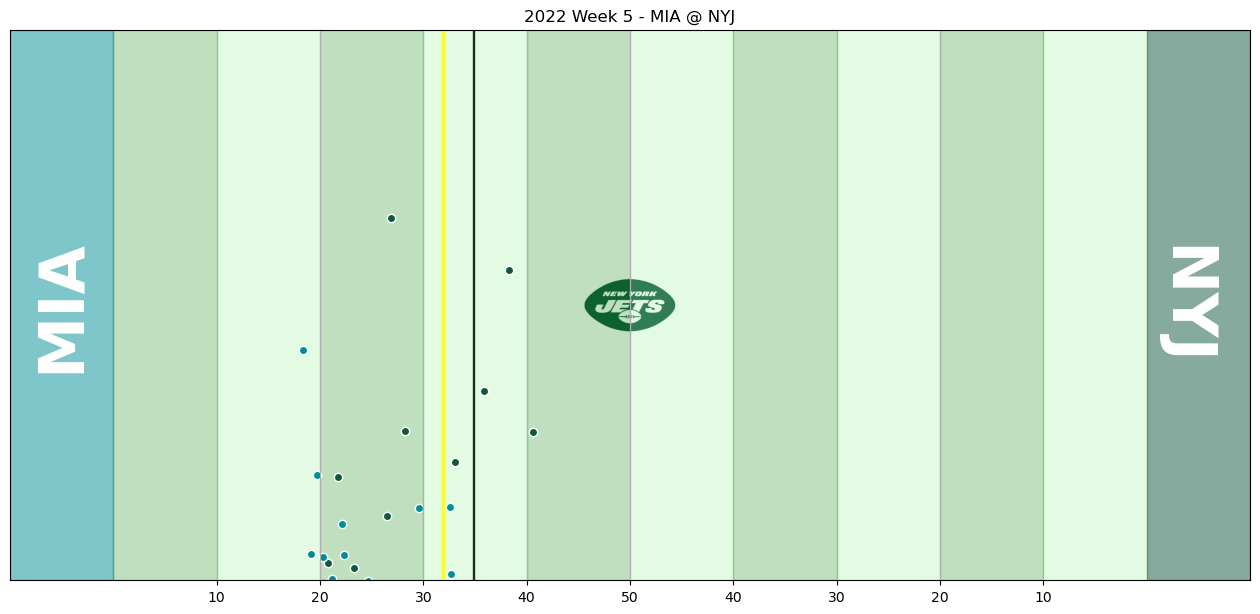

In [90]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

